> memo: 왜 손실함수의 기울기를 가중치 매개변수에 감산을 하는 지 -> 손실함수의 값은 적게 하는 것이 목표이다. 손실함수의 각 가중치 매개변수에 대한 편미분 값은 해당 가중치 매개변수가 손실함수의 결과에 얼마나 영향을 미치는 지에 대한 값이다. 

# 매개변수 최적화 방법

1. 확률적 경사 하강법(SGD)

가장 쉬운 방식

$$W \leftarrow W - \eta\frac{\partial L}{\partial W}$$ 

단점은 비등방성 함수에서 탐색 경로가 비효율적이라는 것.

> SGD 가 지그재그로 탐색하는 근본 원인은 기울어진 방향이 본래의 최솟값과 다른 방향을 가리켜서라는 점도 생각해볼 필요가 있습니다.

2. 모멘텀

$$ v \leftarrow av - \eta\frac{\partial L}{\partial W} $$

속도 변수 v를 추가한다. 기울기 방향으로 힘을 받아 물체가 가속되는 것에 착안. $a$ 는 보통 0.9 설정한다.

3. AdaGrad

$$ h \leftarrow h + \frac{\partial L}{\partial W} * \frac{\partial L}{\partial W} $$
$$ W \leftarrow W - \eta\frac{1}{\sqrt{h}}\frac{\partial L}{\partial W}

학습률을 각 매개변수의 기울기 변화량에 정도에 비례하여 점진적으로 감소시키는 최적화 방법

4. Adam

AdaGrad + Momentum

> [논문참고: Adam: A Method for Stochastic Optimization]

In [1]:
# 파일 경로에 루트 경로 추가
import sys,os
sys.path.append(os.pardir)

In [ ]:
import numpy as np
from collections import OrderedDict
from common.layers import *

class MultiLayer:
  def __init__(self, input_size, hidden_size , output_size, weight_init_std = 0.01):
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

    self.layers = OrderedDict()
    self.layers["Affine1"] = Affine(self.params['W1'], self.params['b1'])
    self.layers["Relu1"] = Relu()
    self.layers["Affine2"] = Affine(self.params['W2'], self.params['b2'])
    
    self.lastLayer = SoftmaxWithLoss()

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)

    return x
  
  def loss(self, x, t):
    y = self.predict(x)
    return self.lastLayer.forward(y, t)
  
  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    if t.ndim != 1 : t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy
  
  def gradient(self, x, t):
    self.loss(x, t)

    dout = 1
    dout = self.lastLayer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    grads = {}
    grads['W1'] = self.layers['Affine1'].dW
    grads['b1'] = self.layers['Affine1'].db
    grads['W2'] = self.layers['Affine2'].dW
    grads['b2'] = self.layers['Affine2'].db

    return grads


In [3]:
from dataset.mnist import load_mnist
from common.optimizer import *

(x_train, t_train), (x_test, t_test)= load_mnist(normalize=True, one_hot_label=True)
network = MultiLayer(784, 50, 10)
optimizer = AdaGrad()

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  grad = network.gradient(x_batch, t_batch)

  optimizer.update(network.params, grad)

  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  if i % batch_size == 0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(train_acc, test_acc)

0.15403333333333333 0.15
0.8732666666666666 0.8785
0.8941166666666667 0.8983
0.9027833333333334 0.9072
0.9061833333333333 0.9106
0.9094 0.9132
0.9121833333333333 0.9154
0.9143833333333333 0.9162
0.9155166666666666 0.917
0.9174333333333333 0.92
0.9198333333333333 0.9208
0.9212833333333333 0.9228
0.9221166666666667 0.9229
0.9233 0.9244
0.9243 0.926
0.9248333333333333 0.9257
0.9259333333333334 0.9264
0.9276833333333333 0.9293
0.9292666666666667 0.9293
0.9290833333333334 0.9297
0.93025 0.9298
0.9318 0.9313
0.9317 0.9311
0.9328666666666666 0.9341
0.9334833333333333 0.9335
0.9333833333333333 0.9318
0.9337833333333333 0.9326
0.9342666666666667 0.9328
0.93485 0.9338
0.9353 0.9339
0.9362333333333334 0.9354
0.9370333333333334 0.9359
0.9379833333333333 0.9371
0.9381666666666667 0.9363
0.93825 0.9384
0.9390166666666667 0.9387
0.9384333333333333 0.9376
0.9390166666666667 0.9382
0.9401166666666667 0.9396
0.9405 0.9397
0.94 0.9395
0.9411 0.9403
0.9413333333333334 0.9399
0.9423333333333334 0.9413
0.94

# 가중치 초기값

가중치 값을 작게하면 오버피팅이 일어나지 않는다.
> Why? 모델에서 가중치카 큰 값이 존재한다고 가정하면, 해당 가중치를 이용하는 입력에 대해서 결과값이 크게 튄다. 모델은 이런 노이즈를 학습하게 되어 데이터에 과적합을 하게 된다.

가중치가 고르게 존재하면 가중치가 여러 개인 의미가 사라진다.

ReLU -> He 초기값
sigmoid, tanh -> Xavier 초기값

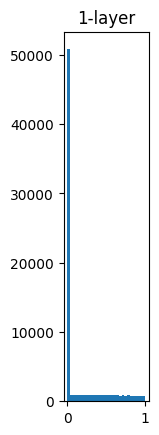

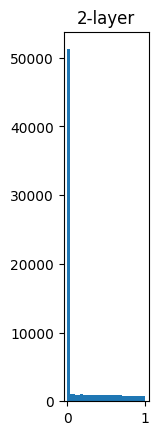

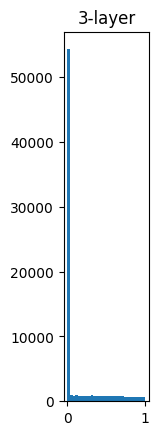

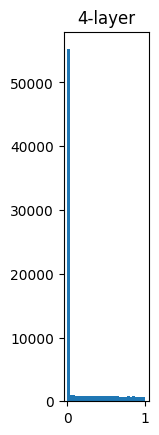

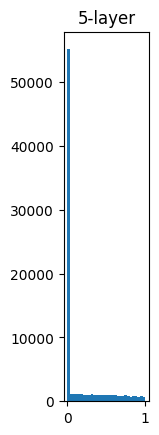

In [ ]:
import matplotlib.pylab as plt

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def relu(x):
  return np.maximum(0, x)

def standardize(x):
  return (x - np.mean(x)) / np.std(x) * 10e-7
  

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_num = 5
activation = {}

for i in range(hidden_layer_num):
  if i != 0:
    x = activation[i-1]
  
  # w = np.random.randn(node_num, node_num) * 1 # 표준편차가 1인 정규분포
  # w = np.random.randn(node_num, node_num) * 0.01 # 표준편차가 0.01인 정규분포
  # w = np.random.randn(node_num, node_num) / np.sqrt(node_num) # Xavier 초기값
  w = np.random.randn(node_num, node_num) * np.sqrt(2) / np.sqrt(node_num)
  a = np.dot(x, w)
  z = relu(a)
  activation[i] = z


for i, a in activation.items():
  plt.subplot(1, len(activation), i+1)
  plt.title(str(i+1) + "-layer")
  plt.hist(a.flatten(), 30, range=(0,1))
  plt.show()


np.std()

# 배치 정규화

